Processing file: bwv302.xml


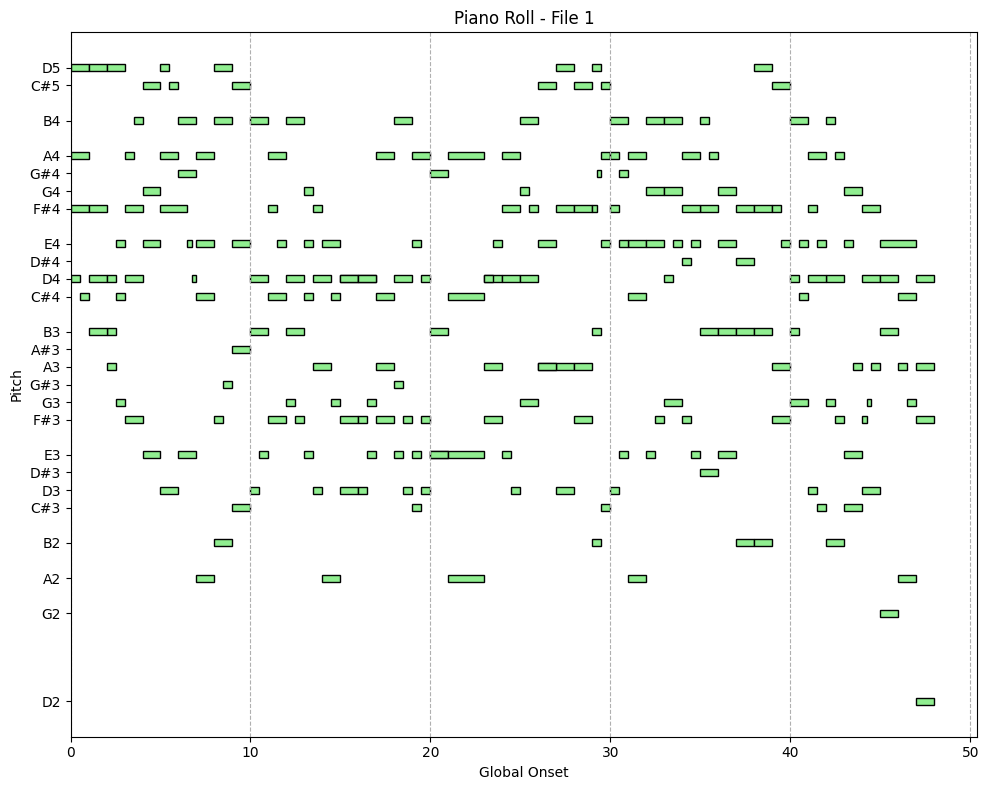

Processing file: https://raw.githubusercontent.com/music-encoding/sample-encodings/main/MEI_5.0/Music/Complete_examples/Bach-JS_Ein_feste_Burg.mei


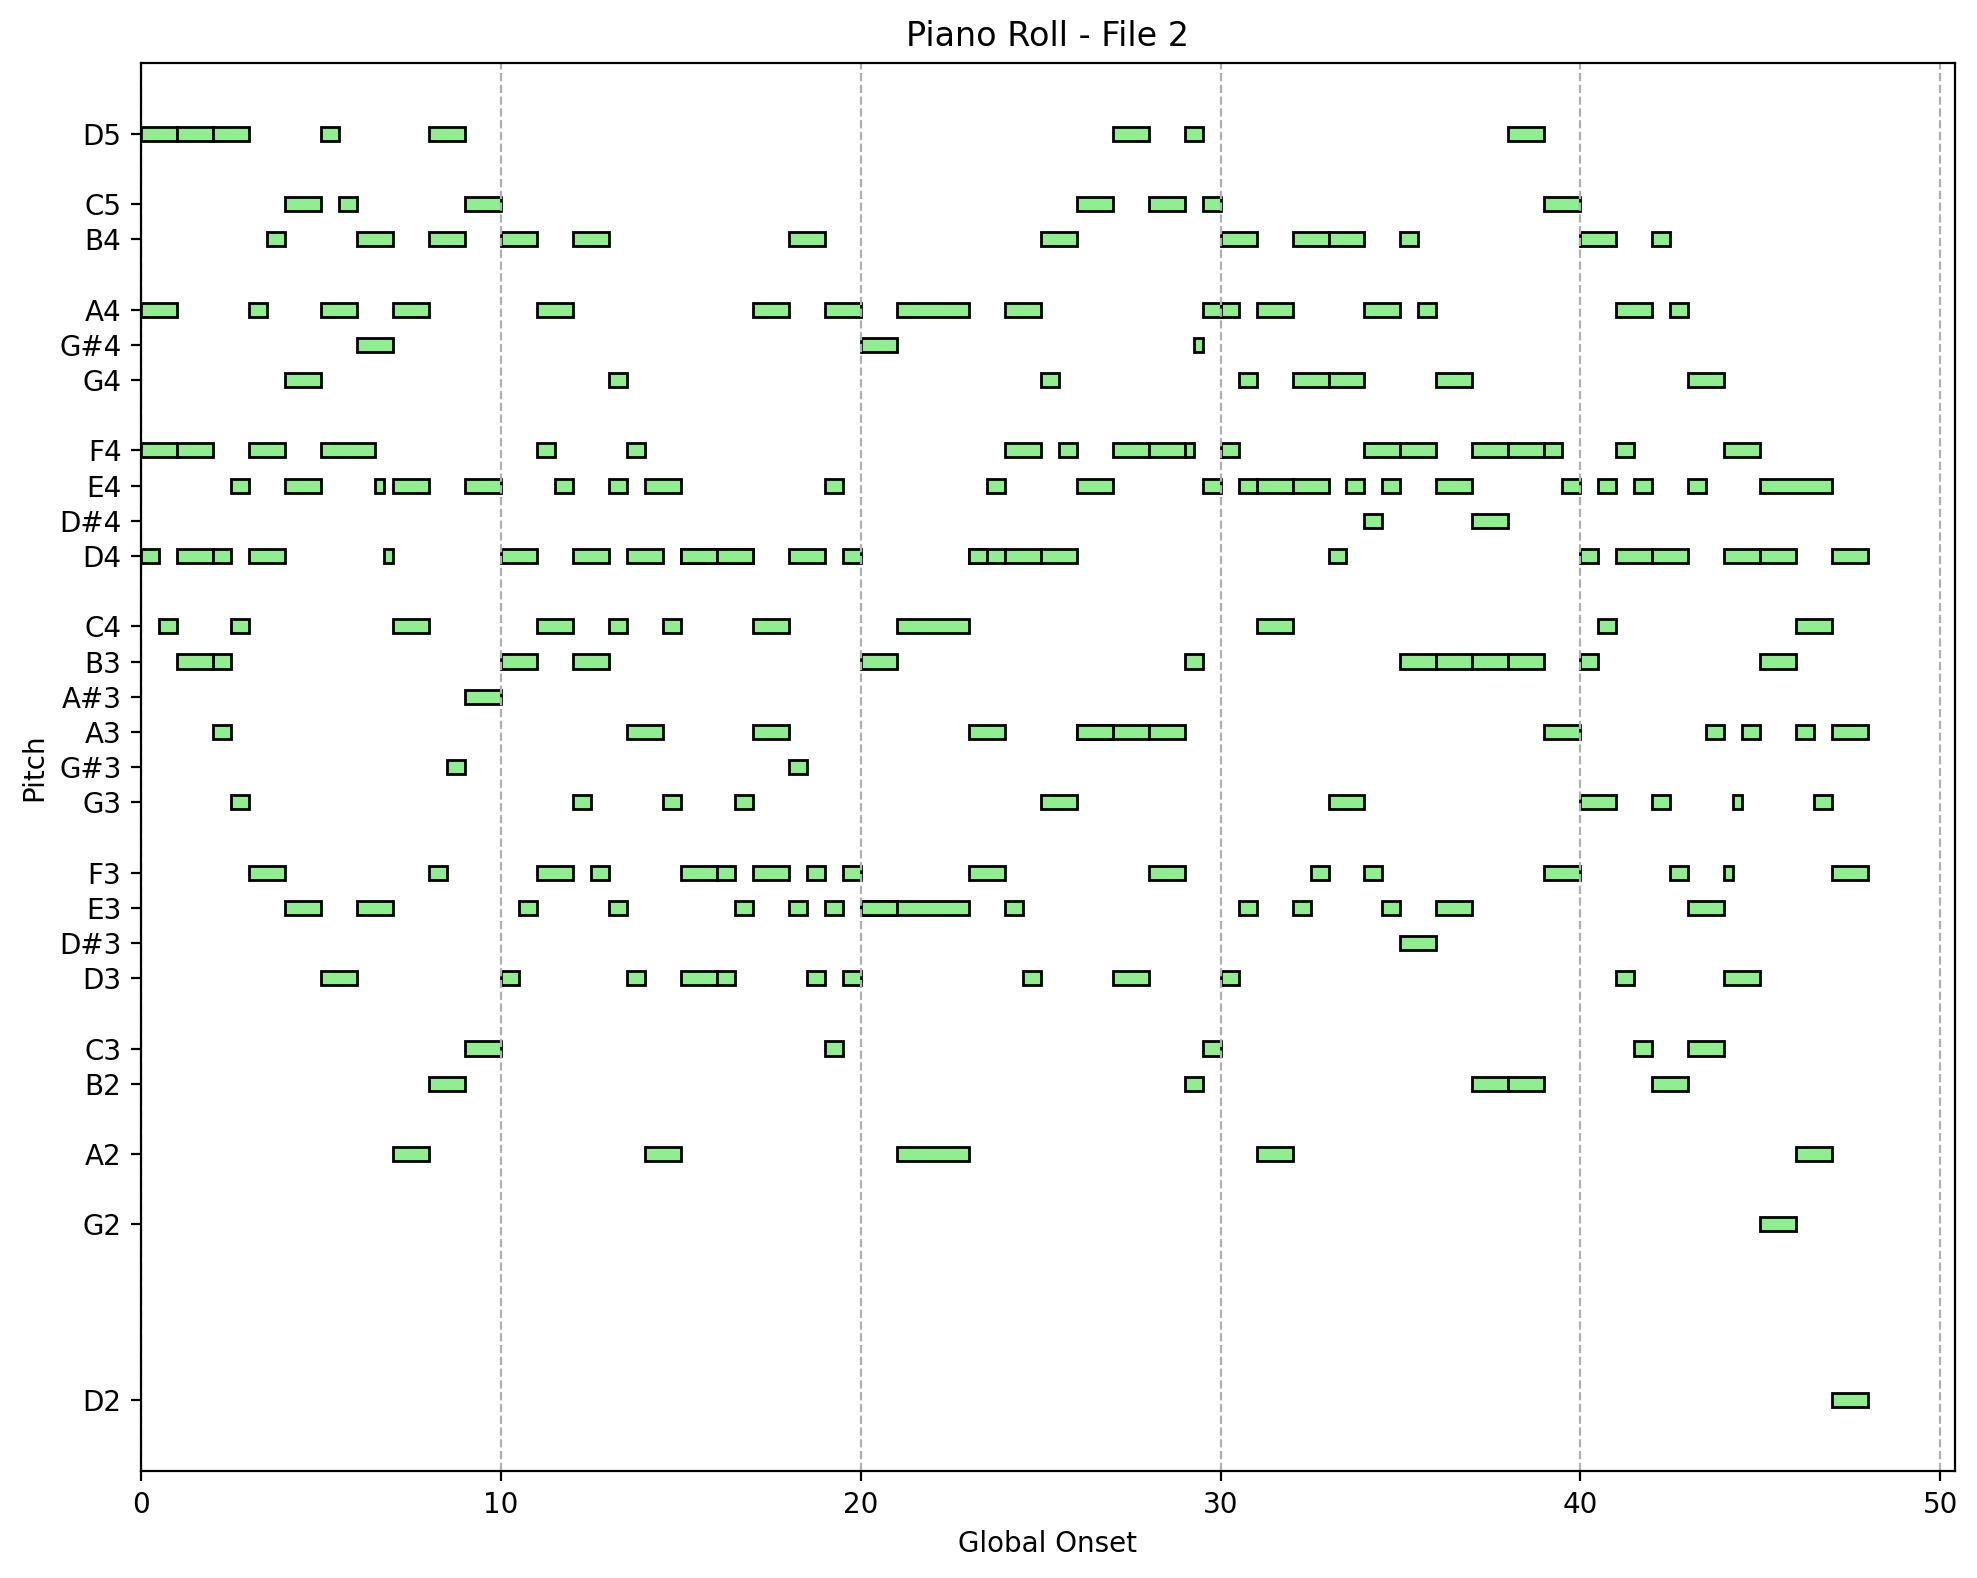

Processing file: https://raw.githubusercontent.com/craigsapp/bach-370-chorales/main/kern/chor020.krn


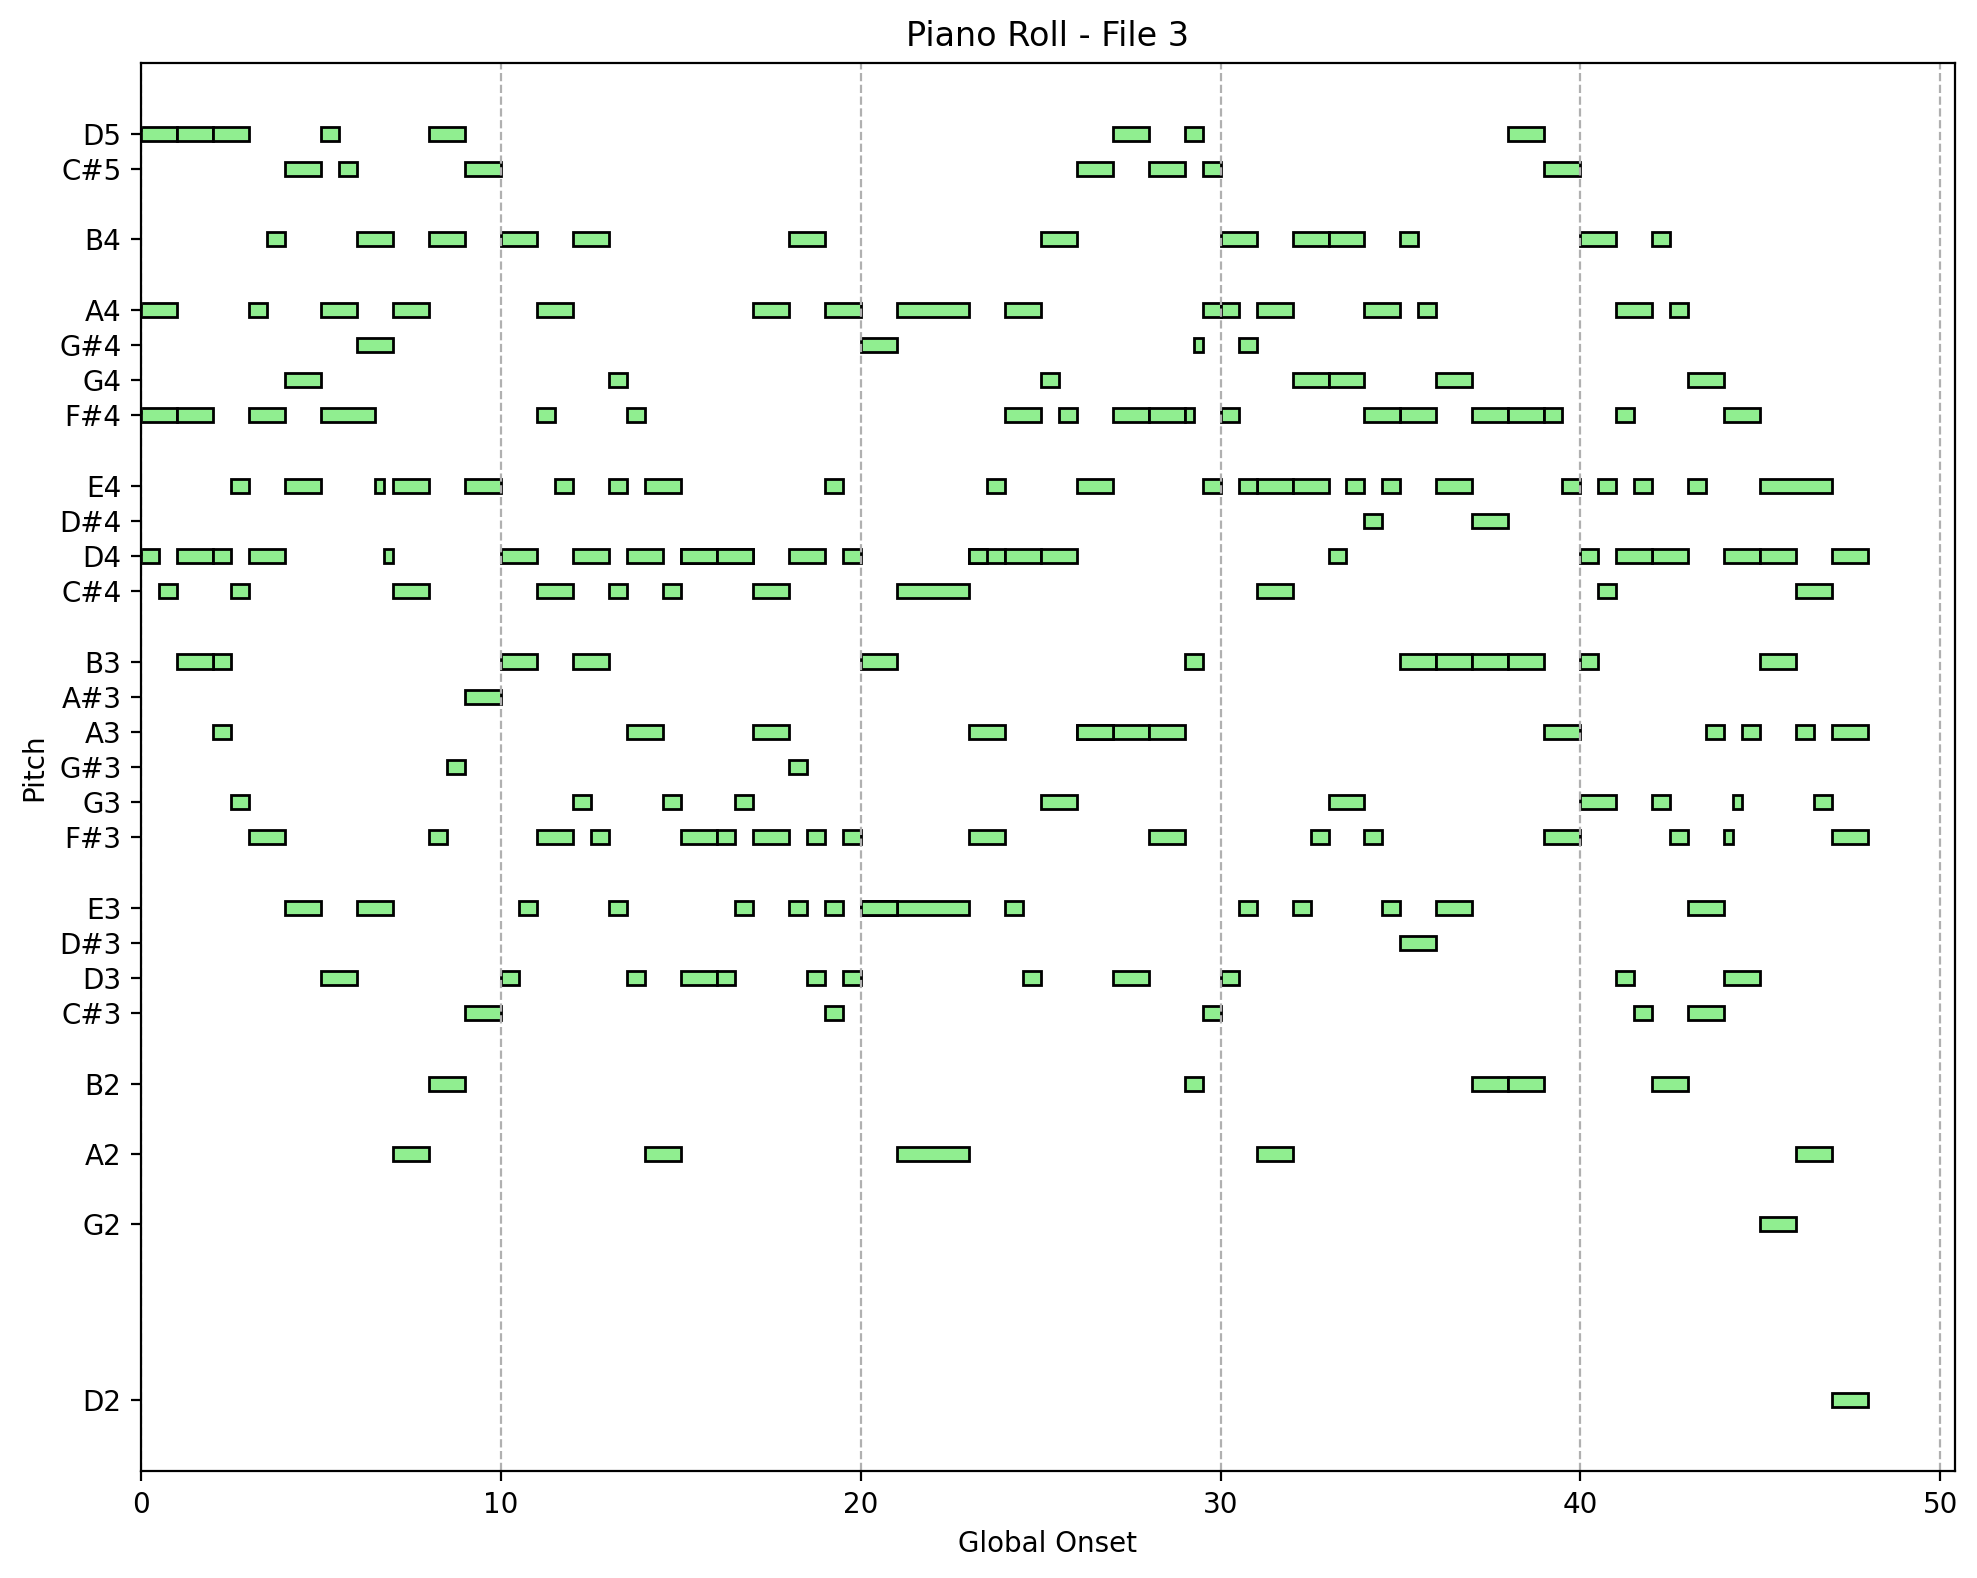

In [1]:
from music21 import converter, note, chord, stream, pitch as pitch_module
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tempfile
import os

def get_file_path(file_source):
    if file_source.startswith(('http://', 'https://')):
        try:
            with requests.get(file_source) as response:
                response.raise_for_status()
                _, file_extension = os.path.splitext(file_source)
                with tempfile.NamedTemporaryFile(delete=False, suffix=file_extension) as temp_file:
                    temp_file.write(response.content)
                    return temp_file.name
        except requests.RequestException as e:
            raise ValueError(f"Error downloading the file: {e}")
    else:
        if os.path.exists(file_source):
            return file_source
        else:
            raise FileNotFoundError("Local file does not exist")

def extract_voice_data(score):
    voice_data = []
    global_offset = 0
    for part in score.parts:
        for measure in part.getElementsByClass(stream.Measure):
            measure_start = measure.offset
            elements = measure.voices if measure.voices else [measure]
            for container in elements:
                for element in container.notesAndRests:
                    if isinstance(element, (note.Note, chord.Chord)):
                        local_offset = element.offset
                        global_offset = measure_start + local_offset
                        duration = element.duration.quarterLength
                        pitches = [str(element.pitch)] if isinstance(element, note.Note) else [str(p) for p in element.pitches]
                        voice_data.extend([(measure.number, local_offset, global_offset, duration, pitch) for pitch in pitches])
    return voice_data

def create_piano_roll(df, file_index):
    midi_to_pitch = {midi: pitch for midi, pitch in zip(df['MIDI'], df['Pitch'])}
    plt.figure(figsize=(10, 8))
    for index, row in df.iterrows():
        plt.barh(row['MIDI'], width=row['Duration'], left=row['Global Onset'], height=0.4, color='lightgreen', edgecolor='black')
    plt.yticks(list(midi_to_pitch.keys()), list(midi_to_pitch.values()))
    plt.xlabel('Global Onset')
    plt.ylabel('Pitch')
    plt.title(f'Piano Roll - File {file_index}')
    plt.grid(True, axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

def filter_and_adjust_durations(df, filter_zero_duration=True, adjust_fractional_duration=True):
    df_processed = df.copy()
    if filter_zero_duration:
        df_processed = df_processed[df_processed['Duration'] > 0]
    if adjust_fractional_duration:
        df_processed['Duration'] = df_processed['Duration'].apply(lambda x: round(x, 3))
        df_processed['Local Onset'] = df_processed['Local Onset'].apply(lambda x: round(x, 3))
        df_processed['Global Onset'] = df_processed['Global Onset'].apply(lambda x: round(x, 3))
    return df_processed

data_frames = []
file_sources = [
    #'https://github.com/MarkGotham/Chorale-Corpus/raw/main/Bach,_Johann_Sebastian/Chorales/020/short_score.mxl',
    'bwv302.xml',
    'https://raw.githubusercontent.com/music-encoding/sample-encodings/main/MEI_5.0/Music/Complete_examples/Bach-JS_Ein_feste_Burg.mei',
    'https://raw.githubusercontent.com/craigsapp/bach-370-chorales/main/kern/chor020.krn'  
]

file_index = 1

for file_source in file_sources:
    try:
        print(f"Processing file: {file_source}")
        file_path = get_file_path(file_source)
        score = converter.parse(file_path)
        voice_data = extract_voice_data(score)
        df = pd.DataFrame(voice_data, columns=['Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch'])
        
        df['MIDI'] = df['Pitch'].apply(lambda x: pitch_module.Pitch(x).midi)
        df_processed = filter_and_adjust_durations(df, filter_zero_duration=True, adjust_fractional_duration=True)
        
        data_frames.append(df_processed)
        create_piano_roll(df_processed, file_index)
        file_index += 1
    except Exception as e:
        print(f"An error occurred processing {file_source}: {e}")


In [2]:
df1 = data_frames[0]  # Access the first DataFrame
df2 = data_frames[1]  # Access the second DataFrame
df3 = data_frames[2]  # Access the third DataFrame
pd.set_option('display.max_rows', 500)

#display(df1)
#display(df2)
#display(df3)

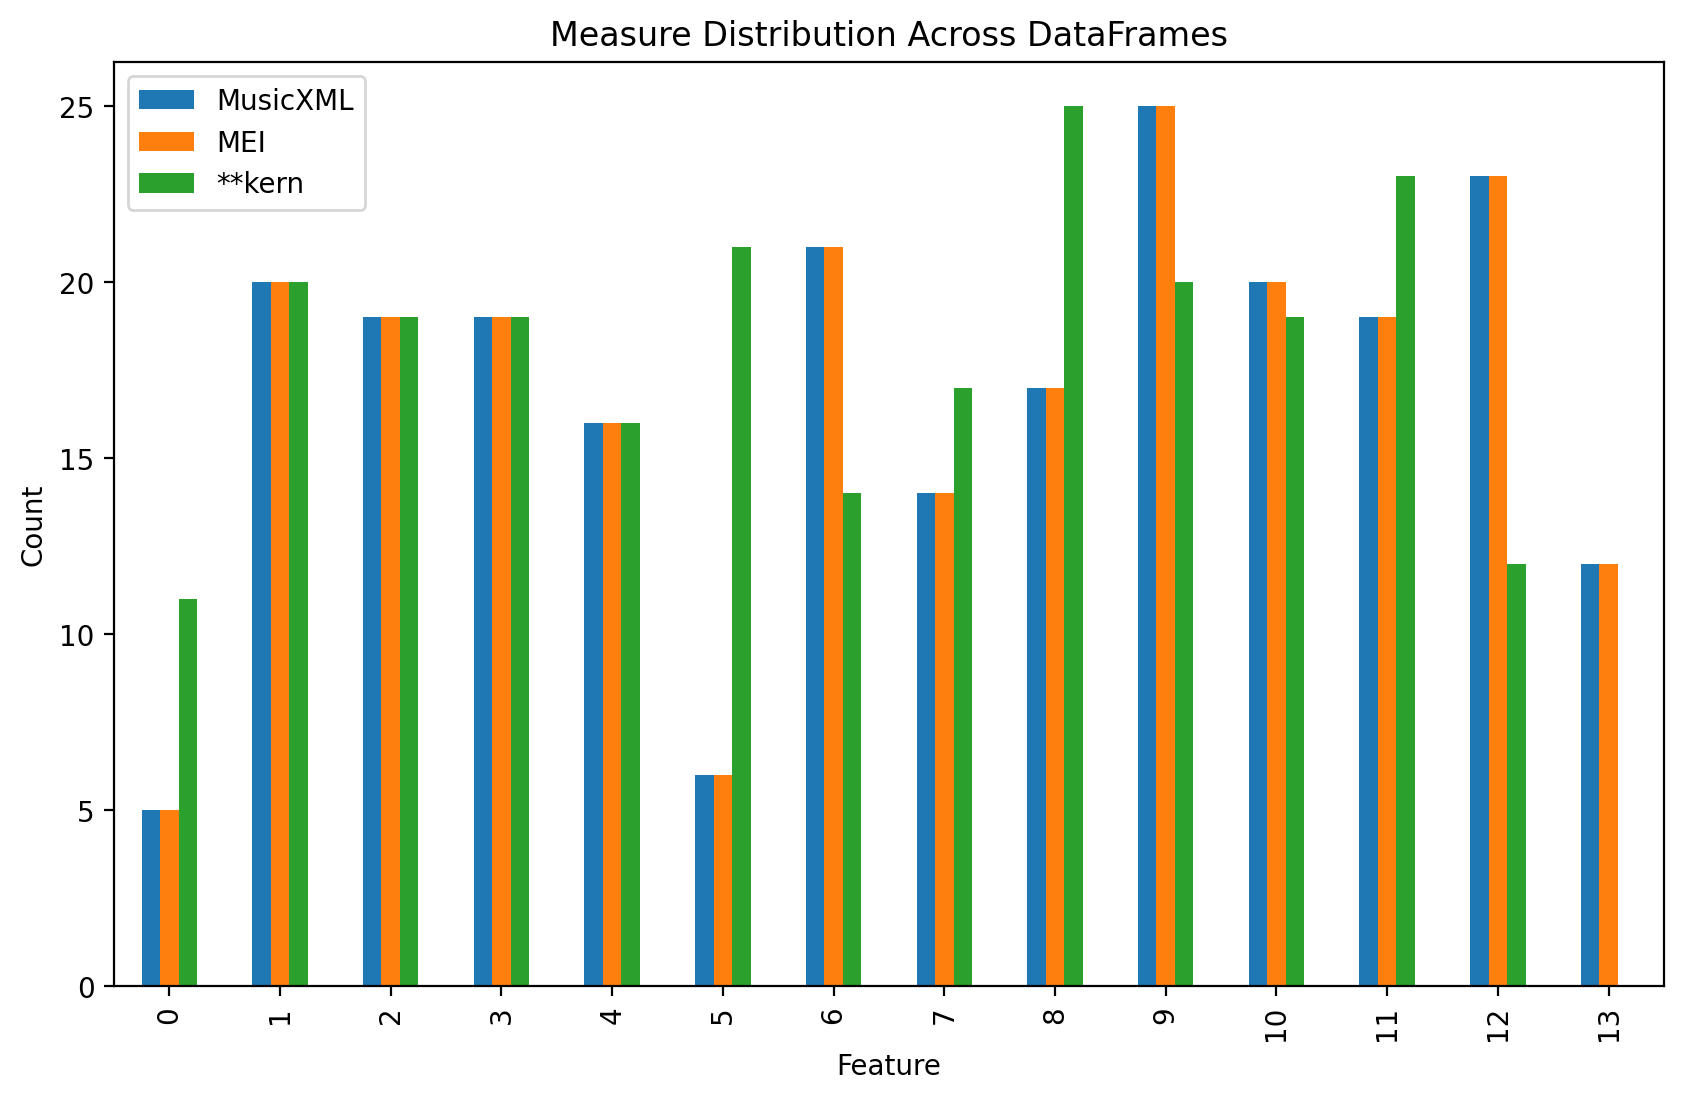

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

feature = 'Measure'

# Function to sort and count values
def process_data(df):
    return df.sort_values(by=feature)[feature].value_counts().sort_index()

# Process each DataFrame
counts1 = process_data(df1)
counts2 = process_data(df2)
counts3 = process_data(df3)

# Create a combined DataFrame from the counts
combined_counts = pd.DataFrame({
    'DF1 Counts': counts1,
    'DF2 Counts': counts2,
    'DF3 Counts': counts3
}).fillna(0)  # Fill NaN values with 0 for consistent plotting

# Plotting
combined_counts.plot(kind='bar', figsize=(10, 6))
plt.title(f'{feature} Distribution Across DataFrames')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.legend(['MusicXML', 'MEI', '**kern'])
plt.show()
